Numero di righe prima della rimozione: 1383
Numero di righe dopo la rimozione: 1159
Training set: (772, 4), Test set: (387, 4)
MAE: 22233.884630289554
MSE: 1795481042.1357043
RMSE: 42373.11697451232
R²: 0.9993992431200465


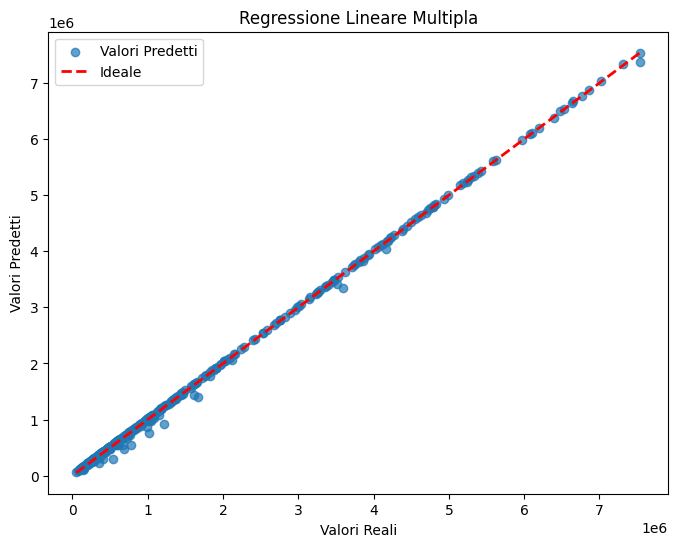

              comune       ato  abitanti  kg di rifiuti differenziati (rdi)  \
0  Aiello del Sabato  Avellino    3988.0                             837843   
1   Altavilla Irpina  Avellino    3960.0                            1036950   
2           Andretta  Avellino    1658.0                             313201   
3          Aquilonia  Avellino    1493.0                             283255   
5          Atripalda  Avellino   10440.0                            3056235   

   kg di rifiuti non differenziati (ruind)  \
0                                 436310.0   
1                                 388120.0   
2                                 162280.0   
3                                 296160.0   
5                                1921640.0   

   totale kg di rifiuti prodotti (rdi+ruind)  anno  
0                                    1274153  2021  
1                                    1438758  2021  
2                                     475481  2021  
3                                   

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Caricare il dataset con rilevamento automatico del separatore
df = pd.read_csv("dataset/dataset_filtrato.csv", sep=None, engine='python')

# Rimuoviamo spazi extra e standardizziamo i nomi delle colonne
df.columns = df.columns.str.strip().str.lower()

# Selezioniamo le colonne numeriche corrette
cols_to_convert = [
    "anno",
    "kg di rifiuti differenziati (rdi)",
    "kg di rifiuti non differenziati (ruind)",
    "totale kg di rifiuti prodotti (rdi+ruind)"
]

# Conversione delle colonne numeriche eliminando separatori di migliaia e convertendo in float
for col in cols_to_convert:
    df[col] = df[col].astype(str).str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Identificare le colonne chiave
col_anno = "anno"
col_comune = "comune"
col_x1 = "kg di rifiuti differenziati (rdi)"
col_x2 = "kg di rifiuti non differenziati (ruind)"
col_target = "totale kg di rifiuti prodotti (rdi+ruind)"

# Funzione per calcolare i limiti degli outlier
def get_outlier_bounds(series, multiplier=1.3):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return lower_bound, upper_bound

# Calcolare i limiti per ogni colonna e filtrare il dataset
bounds = {col: get_outlier_bounds(df[col]) for col in [col_x1, col_x2, col_target]}
df_cleaned = df[
    (df[col_x1].between(bounds[col_x1][0], bounds[col_x1][1])) &
    (df[col_x2].between(bounds[col_x2][0], bounds[col_x2][1])) &
    (df[col_target].between(bounds[col_target][0], bounds[col_target][1]))
]

# Verifica dei dati puliti
print(f"Numero di righe prima della rimozione: {len(df)}")
print(f"Numero di righe dopo la rimozione: {len(df_cleaned)}")

# Aggiorna il dataframe con i dati puliti
df = df_cleaned

# Dividi il dataset in base all'anno
train_set = df[df["anno"].isin([2021, 2022])].copy()  # Aggiungi .copy()
test_set = df[df["anno"] == 2023].copy()  # Aggiungi .copy()

# Separa features (X) e target (y) per train e test
X_train = train_set.select_dtypes(include=[np.number]).drop(columns=[col_target], errors="ignore")
y_train = train_set[col_target]

X_test = test_set.select_dtypes(include=[np.number]).drop(columns=[col_target], errors="ignore")
y_test = test_set[col_target]

# Ora il dataset è diviso correttamente
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# Creazione e addestramento del modello
model = LinearRegression()
model.fit(X_train, y_train)

# Predizioni sul set di addestramento (X_train)
y_pred_train = model.predict(X_train)

# Predizioni sul set di test (X_test)
y_pred_test = model.predict(X_test)

# Aggiungi solo le predizioni per il training set al DataFrame originario usando .loc
train_set.loc[:, 'y_pred'] = y_pred_train

# Aggiungi le predizioni per il test set usando .loc
test_set.loc[:, 'y_pred'] = y_pred_test

# Metriche di valutazione
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_test)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

# Grafico di regressione
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.7, label="Valori Predetti")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Ideale")
plt.xlabel("Valori Reali")
plt.ylabel("Valori Predetti")
plt.title("Regressione Lineare Multipla")
plt.legend()
plt.show()

# Salvare il dataset con le predizioni
df_cleaned_with_preds = pd.concat([train_set, test_set], axis=0)
df_cleaned_with_preds.to_csv("dataset/dataset_senza_outlier.csv", index=False)

# Funzione per predire i valori del 2024 per ogni comune
def predict_2024(group):
    if len(group) < 2:
        return np.nan  
    
    model = LinearRegression()
    X = group[[col_anno, col_x1, col_x2]]  
    y = group[col_target]
    model.fit(X, y)
    
    # Creare un input con l'anno 2024 per fare la previsione
    X_pred = pd.DataFrame({
        col_anno: [2024],  
        col_x1: [group[col_x1].mean()],  # Media dei rifiuti differenziati fino al 2023
        col_x2: [group[col_x2].mean()]   # Media dei rifiuti non differenziati fino al 2023
    })
    
    return model.predict(X_pred)[0]

# Applicare il modello per ogni comune
df_pred = df.groupby(col_comune, group_keys=False)[[col_anno, col_x1, col_x2, col_target]].apply(predict_2024).reset_index()
df_pred.columns = [col_comune, 'predizione_2024']

# Formattare le predizioni
df_pred['predizione_2024'] = df_pred['predizione_2024'].apply(lambda x: f"{x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))

# Salvare il dataset con le predizioni 2024
df_pred.to_csv("dataset/predizioni_2024.csv", index=False)

print(df.head())
